In [23]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix

from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_curve, auc


from keras.utils.np_utils import to_categorical

from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load all deep learning models
three_model = load_model("./model/3_layers_torso.h5")
five_model = load_model("./model/5_layers_torso.h5")
seven_model = load_model("./model/7_layers_torso.h5")
sevenD_model = load_model("./model/7_layers_with_dropout_torso.h5")

# Load input scaler
with open("./model/input_scaler_torso.pkl", "rb") as f:
    sc = pickle.load(f)

In [3]:
def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

In [4]:
# load dataset
test_df = describe_dataset("./torso_test.csv")

# Categorizing label
test_df.loc[test_df["label"] == "torso_correct", "label"] = 0
test_df.loc[test_df["label"] == "torso_error", "label"] = 1

# Standard Scaling of features
test_x = test_df.drop("label", axis = 1)
test_x = pd.DataFrame(sc.transform(test_x))

test_y = test_df["label"].astype('int')

# # Converting prediction to categorical
test_y_cat = to_categorical(test_y)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']
Number of rows: 2449 
Number of columns: 53

Labels: 
torso_correct    2229
torso_error       220
Name: label, dtype: int64

Missing values: False

D

In [5]:
test_set_results = []

model_paths = ["./model/3_layers_torso.h5", 
               "./model/5_layers_torso.h5", 
               "./model/7_layers_torso.h5", 
               "./model/7_layers_with_dropout_torso.h5"]

for path in model_paths:
    model = load_model(path)

    # Evaluate model
    predict_x = model.predict(test_x, verbose=False) 
    y_pred_class = np.argmax(predict_x, axis=1)
    y_test_class = np.argmax(test_y_cat, axis=1)

    cm = confusion_matrix(y_test_class, y_pred_class, labels=[0, 1, 2])
    p_score = precision_score(y_test_class, y_pred_class, average="weighted")
    a_score = accuracy_score(y_test_class, y_pred_class)
    r_score = recall_score(y_test_class, y_pred_class, average="weighted")
    f1_score_result = f1_score(y_test_class, y_pred_class, average="weighted")
    
    test_set_results.append(( path,  p_score, r_score, a_score, f1_score_result, cm ))

dp_eval = pd.DataFrame(test_set_results, columns=["Model Path", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score", "Confusion Matrix"])

dp_eval

,Model Path,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,./model/3_layers_torso.h5,0.932213,0.935076,0.935076,0.933452,"[[2161, 68, 0], [91, 129, 0], [0, 0, 0]]"
1,./model/5_layers_torso.h5,0.917976,0.928134,0.928134,0.919361,"[[2187, 42, 0], [134, 86, 0], [0, 0, 0]]"
2,./model/7_layers_torso.h5,0.915594,0.926092,0.926092,0.917692,"[[2182, 47, 0], [134, 86, 0], [0, 0, 0]]"
3,./model/7_layers_with_dropout_torso.h5,0.929763,0.935484,0.935484,0.931533,"[[2176, 53, 0], [105, 115, 0], [0, 0, 0]]"


In [6]:
best_model01 = five_model
y_predictions = best_model01.predict(test_x)

# convert continuous values to discrete labels using a threshold of 0.5
y_predictions_labels = (y_predictions >= 0.5).argmax(axis=-1)

p_score = precision_score(test_y, y_predictions_labels, labels=[0, 1], average=None)
r_score = recall_score(test_y, y_predictions_labels, labels=[0, 1], average=None)
f1_score_result = f1_score(test_y, y_predictions_labels, labels=[0, 1], average=None)

p_score, r_score, f1_score_result

77/77 [==============================] - 0s 3ms/step


(array([0.94226626, 0.671875  ]),
 array([0.98115747, 0.39090909]),
 array([0.96131868, 0.49425287]))

In [7]:
(0.961 + 0.494) / 2

0.7275

<AxesSubplot:>

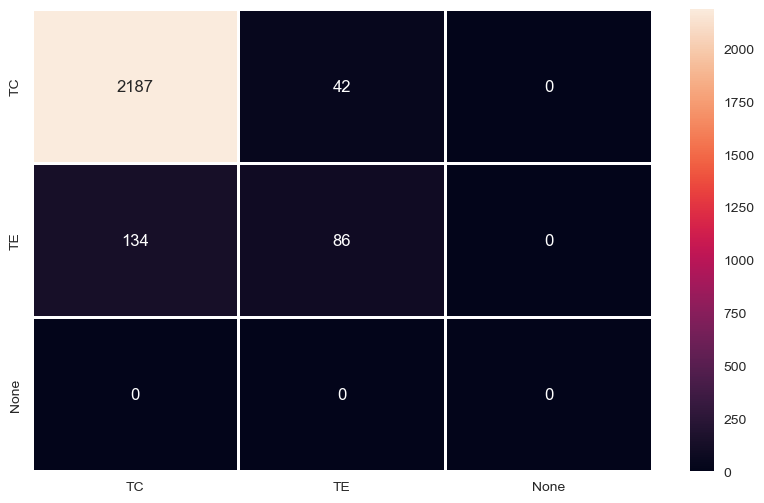

In [13]:
LR_cm = dp_eval[dp_eval["Model Path"] == './model/5_layers_torso.h5']["Confusion Matrix"].values[0]


cm_array_df = pd.DataFrame(LR_cm, index=["TC", "TE", "None"], columns=["TC", "TE", "None"])

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cm_array_df, linewidths=1, annot=True, ax=ax, fmt='g')

In [25]:
def to_labels(y_pred, y_pred_proba, threshold):
    '''Return prediction taking confidence threshold into account'''
    results = []

    for index, predicted_class in enumerate(y_pred):
        prediction_probabilities = y_pred_proba[index]
        class_prediction_probability = round(prediction_probabilities[np.argmax(prediction_probabilities)], 2)

        results.append(predicted_class if class_prediction_probability >= threshold else -1)
    
    return results


def calculate_correlation_score_confidence(test_x, test_y):
    '''Calculate correlation between Precision score/Recall score/F1 score and confidence threshold'''
    y_predictions = best_model01.predict(test_x)
    y_predict_proba = tf.nn.softmax(y_predictions)

    thresholds = list(np.arange(0, 1.01, 0.01))
    f1_scores = []
    for threshold in thresholds:
        y_pred_bin = tf.cast(y_predict_proba[:,1] > threshold, tf.int32)
        f1 = f1_score(test_y, y_pred_bin.numpy(), average=None)
        f1_scores.append(f1)

    return thresholds, f1_scores

77/77 [==============================] - 0s 3ms/step
Thresholds: [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0]
F1 Scores: [array([0.        , 0.16485575]), array([0.        , 0.16485575]), array([0.        , 0.16485575]), array([0.        , 0.16485575]), array([0.        , 0.16485575]), array([0.        ,

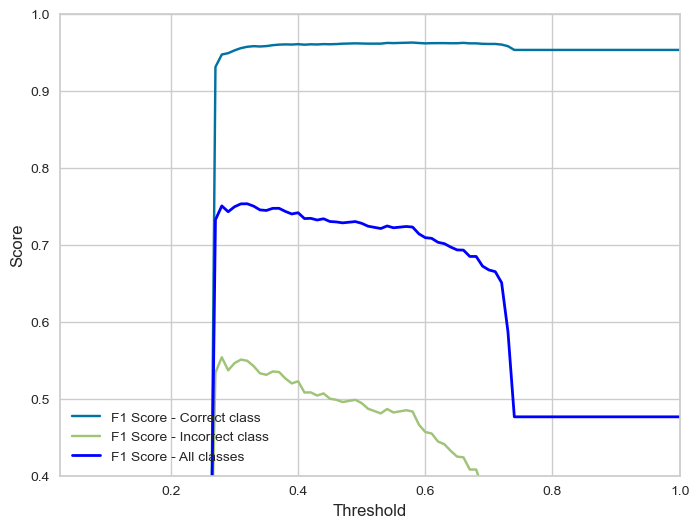

In [27]:
thresholds, f1_scores = calculate_correlation_score_confidence(test_x, test_y)

first_class = [ el[0] for el in f1_scores ]
second_class = [ el[1] for el in f1_scores ]
all_classes = [(el[0] + el[1]) / 2 for el in f1_scores]

print("Thresholds:", thresholds)
print("F1 Scores:", f1_scores)

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(thresholds, first_class, label = "F1 Score - Correct class")
plt.plot(thresholds, second_class, label = "F1 Score - Incorrect class")
plt.plot(thresholds, all_classes, label = "F1 Score - All classes", linewidth=2.0, color="blue")
plt.legend(loc = 'lower left')
plt.ylim([0.4, 1])
plt.xlim([0.025, 1])
plt.xlabel("Threshold", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
# plt.axvline(thresholds[np.argmin(abs(precision-recall))], color="k", ls = "--")
# plt.title(label = F"Threshold = {thresholds[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
plt.show()

77/77 [==============================] - 0s 2ms/step
Optimal Threshold: 4.648246613214724e-05


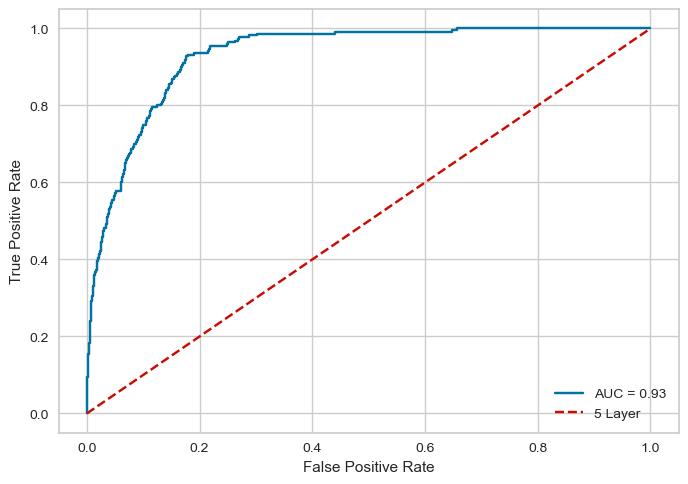

In [28]:
# calculate the fpr and tpr for all thresholds of the classification
probs = best_model01.predict(test_x)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# method I: plt
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label="5 Layer")
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()